# 6.2 연관규칙 결과

### 포함 내용
- 연관규칙 기존 모델링 결과
- Calibration
- XAI
- Probability Distribution
- Final 모델 평가 지표

#### 폴더 생성필요
- `../data/` 경로에 `association_rule` 폴더 생성
- `../data/association_rule/` 경로에 `image`, `save_model`, `metric` 폴더 생성 필요

#### 기존 모델링 결과 (Calibration 전) 
- 저장위치 : `../data/association_rule/metric`
- 파일이름 : `{category_name}_기존모델링_예측결과.csv`
    
#### Calibration 결과   
- Calibration 결과 저장위치 : `../data/association_rule/metric`
- Calibration 결과 파일이름 : `{category_name}_metric.csv`
- Calibration Curve 이미지 저장 위치 : `../data/카테고리이름/image/`
- Calibration Curve 이미지 파일이름 :`{category_name}_calibration_curve.png`

#### XAI 결과
- 따로 저장하지 않음

#### FINAL 모델 평가 지표
- 저장위치 :  `../data/{category_name}/metric/`
- 파일이름 : `{category_name}_final_bestmodel_모델링_예측결과.csv`

#### Probability Distribution 
- 그래프 저장 위치 : `../data/association_rule/image/`
- 그래프 이미지 이름 : `{category_name}_probability_distribution.png`

#### 우선순위
- 따로 저장하지 않음
- 맨 아래에 위치

In [44]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
import time
from math import ceil
from IPython.display import display, Markdown
import joblib
import pickle
from tqdm.auto import tqdm
from tqdm import tqdm_notebook as tqdm
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] ='AppleGothic'
from sklearn.preprocessing import StandardScaler


# 분류 알고리즘
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC

# 분류용 평가 함수
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# Calibration
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss
# XAI
# import shap

pd.set_option('display.max_columns', None)

In [45]:
# sklearn version 
import sklearn
print(sklearn.__version__)

1.3.2


# Label Encoding 

In [46]:
# list(air_df['보유멤버십포인트'].unique())

label_list1 = ['0',  '1만↓', '3만↓', '5만↓', '10만↓','20만↓', '30만↓', '30만↑']

label_dict1 = {value: index for index, value in enumerate(label_list1)}

In [47]:
# list(air_df['최근3년구매금액'].unique())
label_list2 = ['0원', '1KK미만', '1KK이상3KK미만','3KK이상5KK미만',  '5KK이상10KK미만','10KK이상15KK미만',
 '15KK이상20KK미만','20KK이상25KK미만','25KK이상30KK미만', '30KK↑']

label_dict2 = {value: index for index, value in enumerate(label_list2)}

In [48]:
# list(air_df['포인트사용빈도'].unique())
label_list3 = ['미사용','1~2회', '3~4회', '5~6회','7~8회','9~10회','11~12회','13~14회','15~16회','17~18회','19~20회', '20회↑']

label_dict3 = {value: index for index, value in enumerate(label_list3)}

In [49]:
# list(air_df['아파트평형대'].unique())
label_list4 = ['Missing', '10평대↓', '10평대', '20평대', '30평대', '40평대', '50평대', '60평대','70평대↑']

label_dict4 = {value: index for index, value in enumerate(label_list4)}

In [50]:
# list(air_df['아파트시세'].unique())
label_list5 = [ 'Missing', '1억↓', '1~2억', '3~4억', '5~6억', '7~8억', '9~10억', '11~15억', '16~29억','30억↑']

label_dict5 = {value: index for index, value in enumerate(label_list5)}

In [51]:
# list(air_df['금액'].unique())
label_list6 = ['Missing', '','0만원 이상 100만원 이하', '100만원 이상 200만원 이하', '200만원 이상 300만원 이하', 
               '300만원 이상 400만원 이하', '400만원 이상 500만원 이하', '500만원 이상 600만원 이하',
       '600만원 이상 700만원 이하', '700만원 이상 800만원 이하', '800만원 이상 900만원 이하', '900만원 이상 1000만원 이하', '1000만원 이상']

label_dict6 = {value: index for index, value in enumerate(label_list6)}

In [52]:
# list(air_df['월'].unique())
label_list7 = ['', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

label_dict7 = {value: index for index, value in enumerate(label_list7)}

In [53]:
# list(health_df['연령대'].unique())
label_list8 = ['Missing', '10대', '20대', '30대', '40대', '50대', '60대(60~64)', '60대(65~69)', '70대', '80대↑']
label_dict8 = {value: index for index, value in enumerate(label_list8)}

In [54]:
def mapping_(df):
    for i in range(1, 9):
        if f'금액_{i}' in df.columns:
            df[f'금액_{i}'] = df[f'금액_{i}'].map(label_dict6)

    for i in range(1, 9):
        if f'월_{i}' in df.columns:
            df[f'월_{i}'] = df[f'월_{i}'].map(label_dict7)

    df['보유멤버십포인트'] = df['보유멤버십포인트'].map(label_dict1)
    df['최근3년구매금액'] = df['최근3년구매금액'].map(label_dict2)
    df['포인트사용빈도'] = df['포인트사용빈도'].map(label_dict3)
    df['아파트평형대'] = df['아파트평형대'].map(label_dict4)
    df['아파트시세'] = df['아파트시세'].map(label_dict5)
    df['연령대'] = df['연령대'].map(label_dict8)
    return df

# One-hot encoding & Train-test split

In [55]:
def split_df(df):
    onehot_col = ['멤버십고객여부', '케어십가입여부',
           '최근구매채널', '주거형태', '멤버십가입경로', '제휴카드보유여부', '프리미엄카드보유여부', '제휴가입여부',
           '멤버십앱설치여부', '거주광역명', '거주시군구명', '타겟제품명_1', '타겟제품명_2', '타겟제품명_3',
                   '타겟제품명_4', '타겟제품명_5', '타겟제품명_6', '타겟제품명_7', '타겟제품명_8', '주구매제품카테고리']
    
    # Convert columns in onehot_col to string
    for col in onehot_col:
        df[col] = df[col].astype(str)

    # 원핫 인코딩
    df_encoded = pd.get_dummies(df[onehot_col])
    
    df_encoded = pd.concat([df_encoded, df[['보유멤버십포인트', '최근3년구매금액', '포인트사용빈도', '아파트평형대', '아파트시세',
                                            '건강관리가전품목수', '총구매빈도', '케어솔루션품목수', '케어십품목수', 
                                            'Only&Best품목수', '최대구매가격대', '연령대',
                                            '금액_1', '금액_2', '금액_3', '금액_4', '금액_5', '금액_6', '금액_7', '금액_8',
                                            '년도_1', '년도_2', '년도_3', '년도_4', '년도_5', '년도_6', '년도_7', '년도_8', 
                                            '월_1', '월_2', '월_3', '월_4', '월_5', '월_6', '월_7', '월_8', 
                                            'label_y']]], axis = 1)
    
    X = df_encoded.drop('label_y', axis=1)
    y = df_encoded['label_y']
    column_names = X.columns
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_scaled_df = pd.DataFrame(X_scaled, columns=column_names)
    
    X_train, X_val, y_train, y_val = train_test_split(X_scaled_df, y, test_size=0.25, random_state = 42)
    
    return X_train, X_val, y_train, y_val



# Calibration Curve, 기존 모델링 결과

In [56]:
def ece_score(y_true, y_prob, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='uniform')
    # 실제로 계산된 빈의 개수에 맞춰 빈의 개수를 조정합니다.
    bin_counts = np.histogram(y_prob, bins=n_bins, range=(0,1))[0]
    ece = np.sum(np.abs(prob_true - prob_pred) * bin_counts[:len(prob_true)]) / np.sum(bin_counts)
    return ece


def cali_curve_model(category_name, X_train, y_train, X_val, y_val):
    pred_list = []
    
    be_af = {
            'category' : [],
          "brier": [],
          "ece": []
        }
    
    pred_df = {
            "모델": [],
              "예측확률": []
            }
    
    # 모델 정의
    models = {
        'Logistic': LogisticRegression(max_iter=1000, random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
    }

    # 모델 정의 및 색상 지정
    model_colors = {
        'Logistic': 'blue',
        'Decision Tree': 'green',
        'Random Forest': 'orange',
        'AdaBoost': 'red',
        'Gradient Boosting': 'cyan'
    }
    
    # 평가 결과를 담을 딕셔너리
    dict1 = {
        'accuracy' : [],
        'precision' : [],
        'recall' : [],
        'f1' : [],
        'roc_auc' : [],
        'model_name' : [],
    }

    # 보정 곡선
    plt.figure(figsize=(15, 12))
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    for name, model in models.items():
        # 기존 모델 학습
        model.fit(X_train, y_train)
        pred = model.predict(X_val)
        pred_list.append(pred)
        
        # Calibration
        calibrated_model = CalibratedClassifierCV(model, method='sigmoid', cv=5)
        calibrated_model.fit(X_val, y_val)

        # 보정 전 예측 확률 계산
        preds = model.predict_proba(X_val)[:, 1]
        # 보정 후 예측 확률 계산
        preds_calibrated = calibrated_model.predict_proba(X_val)[:, 1]


        # calibration_model
        with open(f'../data/association_rule/save_model/{category_name}_{name}_calibration_model.pkl', 'wb') as f:
            pickle.dump(calibrated_model, f)
        # uncalibration_model
        with open(f'../data/association_rule/save_model/{category_name}_{name}_uncalibration_model.pkl', 'wb') as f:
            pickle.dump(model, f)
            
            
        # 모델 색상
        color = model_colors[name] 

        # 보정 곡선 계산
        prob_true, prob_pred = calibration_curve(y_val, preds, n_bins=10)
        plt.plot(prob_pred, prob_true, linestyle='--', color=color, marker='o', label=f'{name} (Uncalibrated)')

        prob_true_calibrated, prob_pred_calibrated = calibration_curve(y_val, preds_calibrated, n_bins=10)
        plt.plot(prob_pred_calibrated, prob_true_calibrated, linestyle='-', color=color, marker='x', label=f'{name} (Calibrated)')   

    
        # ECE 점수
        ece_before = ece_score(y_val, preds, n_bins=10)
        ece_after = ece_score(y_val, preds_calibrated, n_bins=10)

        # 브라이어 점수
        brier_before = brier_score_loss(y_val, preds)
        brier_after = brier_score_loss(y_val, preds_calibrated)

        
        
        # Brier, ECE metric DataFrame
        be_af['category'].append(f'{name}-Uncalibrated')
        be_af['category'].append(f'{name}-Calibrated')
        be_af['brier'].append(brier_before)
        be_af['brier'].append(brier_after)
        be_af['ece'].append(ece_before)
        be_af['ece'].append(ece_after)
    
       
    # calibration metric to dataframe
    calibration_metric = pd.DataFrame(be_af)
    calibration_metric.to_csv(f'../data/association_rule/metric/{category_name}_metric.csv', encoding = 'utf-8-sig')
    print(calibration_metric)
    
   
    model = ['Logistic', 'Decision Tree', 'Random Forest', 'AdaBoost', 'Gradient Boosting']
    
    # 기존 모델 학습 후 모델별 예측 결과
    for idx, p1 in enumerate(pred_list) :
    
        r1 = accuracy_score(y_val, p1)
        r2 = precision_score(y_val, p1)
        r3 = recall_score(y_val, p1)
        r4 = f1_score(y_val, p1)
        r5 = roc_auc_score(y_val, p1)

        dict1['accuracy'].append(r1)
        dict1['precision'].append(r2)
        dict1['recall'].append(r3)
        dict1['f1'].append(r4)
        dict1['roc_auc'].append(r5)
        dict1['model_name'].append(model[idx])
    
    df100 = pd.DataFrame(dict1)
    df100.to_csv(f'../data/association_rule/metric/{category_name}_기존모델링_예측결과.csv', encoding = 'utf-8-sig')
    
    # calibration curve
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title(f'Calibration curves ({category_name})')
    plt.legend(loc='best')
    
    plt.savefig(f'../data/association_rule/image/{category_name}_calibration_curve.png')
    plt.show()                

# XAI

In [57]:
def xai_feature_importance(category_name, bestmodel, X_train):
    with open(f'../data/association_rule/save_model/{category_name}_{bestmodel}_calibration_model.pkl', 'rb') as f:
        xai_model = pickle.load(f)
        
    xai_explainer = shap.Explainer(xai_model.predict_proba, X_train)
    xai_shap_values = xai_explainer(X_train)
    
    shap.plots.bar(xai_shap_values[:,:,1])
    
    plt.title("SHAP Feature Importance")
    print("Type of xai_shap_values:", type(xai_shap_values))
    plt.show()

In [58]:
def xai_feature_importance_mean(category_name, bestmodel, X_train):
    with open(f'../data/association_rule/save_model/{category_name}_{bestmodel}_calibration_model.pkl', 'rb') as f:
        xai_model = pickle.load(f)
    xai_explainer = shap.Explainer(xai_model.predict_proba, X_train)
    xai_shap_values = xai_explainer(X_train)
    
    # NumPy 배열로 변환 (필요한 경우)
    if not isinstance(xai_shap_values, np.ndarray):
        xai_shap_values = xai_shap_values.values

    # 모든 클래스에 대한 평균 SHAP 값을 계산합니다.
    shap_values_mean = np.mean(xai_shap_values, axis=-1)

    shap.summary_plot(shap_values_mean, X_train, plot_type="bar")
    plt.title("SHAP Feature Importance")
    plt.show()
    

# Probability Distribution (Uncali, Calibration 시각화)

In [59]:
def plot_proba_dist(category_name, bestmodel, X_val):
    
    with open(f'../data/association_rule/save_model/{category_name}_{bestmodel}_calibration_model.pkl', 'rb') as f:
        cali_model = pickle.load(f)
    with open(f'../data/association_rule/save_model/{category_name}_{bestmodel}_uncalibration_model.pkl', 'rb') as f:
            uncali_model = pickle.load(f)

    # 보정 전 예측 확률 계산
    uncali_pred = uncali_model.predict_proba(X_val)[:, 1]
    # 보정 후 예측 확률 계산
    cali_pred = cali_model.predict_proba(X_val)[:, 1]



    # 시각화
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    # Uncalibrated
    sns.histplot(uncali_pred, bins=10, kde=False, color='skyblue', stat='count', element='bars', ax=axes[0])
    axes[0].set_xlabel('Predicted Scores')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Uncalibrated - Probability Distribution')
    axes[0].set_xlim(0,1)
    
    # Calibrated
    sns.histplot(cali_pred, bins=10, kde=False, color='skyblue', stat='count', element='bars', ax=axes[1])
    axes[1].set_xlabel('Predicted Scores')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Calibrated - Probability Distribution')
    axes[1].set_xlim(0,1)

    plt.tight_layout()

    plt.savefig(f'../data/association_rule/image/{category_name}_probability_distribution.png')
    plt.show()

# Final 모델 평가 지표

In [88]:
def final_metric(category_name, bestmodel, calibration,  X_val, y_val):
    with open(f'../data/association_rule/save_model/{category_name}_{bestmodel}_{calibration}_model.pkl', 'rb') as f:
            cali_model = pickle.load(f)

    y_pred = cali_model.predict(X_val)

    # 평가 결과를 담을 딕셔너리
    dict2 = {
        'accuracy' : [],
        'precision' : [],
        'recall' : [],
        'f1' : [],
        'roc_auc' : []
    }



    # 기존 모델 학습 후 모델별 예측 결과    
    r1 = accuracy_score(y_val, y_pred)
    r2 = precision_score(y_val, y_pred)
    r3 = recall_score(y_val, y_pred)
    r4 = f1_score(y_val, y_pred)
    r5 = roc_auc_score(y_val, y_pred)

    dict2['accuracy'].append(r1)
    dict2['precision'].append(r2)
    dict2['recall'].append(r3)
    dict2['f1'].append(r4)
    dict2['roc_auc'].append(r5)

    df200 = pd.DataFrame(dict2)
    df200.to_csv(f'../data/association_rule/metric/{category_name}_final_모델링_예측결과.csv', encoding = 'utf-8-sig')
    return df200

# 각 카테고리

- 시그니처냉장고 -> 냉장고로 바꾸기
- 시그니처세탁기 -> 세탁기로 바꾸기
- 시그니처공청기 -> 공기청정기 
- 시그니처에어컨 -> 에어컨
- 시그니처TV -> TV로 포함 
- 광파오븐, 시그니처기타 -> 


# 묶인 결과 

1) 'TV', '에어컨', '냉장고', '세탁기'
2) '건조기', '스타일러', '공기청정기', '청소기'
3) '김치냉장고', '식기세척기', '전기레인지', '정수기'
4) '미니워시', 'PC', '휴대폰', '뷰티기기'
5) '로봇청소기', '얼음정수기냉장고', 'AV', '워시타워'
6) 모니터, 안마의자

## 그룹1

In [63]:
group1_df = pd.read_csv('../data/association_rule/group1_df_값생성_2023제거.csv', index_col = 0)

for i in range(1, 9):    
    group1_df.loc[group1_df[f'년도_{i}'].isnull(), f'년도_{i}'] = 0
    
group1_df = group1_df.fillna('')

group1_df = mapping_(group1_df)

X_train1, X_val1, y_train1, y_val1 = split_df(group1_df)

In [64]:
print(f'group1 총 데이터 개수: {len(group1_df)}')
print(f'group1 X_train 데이터 개수: {len(X_train1)}')
print(f'group1 y_train 데이터 개수: {len(y_train1)}')
print(f'group1 X_val 데이터 개수: {len(X_val1)}')
print(f'group1 y_val 데이터 개수: {len(y_val1)}')

group1 총 데이터 개수: 93746
group1 X_train 데이터 개수: 70309
group1 y_train 데이터 개수: 70309
group1 X_val 데이터 개수: 23437
group1 y_val 데이터 개수: 23437


                         category     brier       ece
0           Logistic-Uncalibrated  0.086177  0.008504
1             Logistic-Calibrated  0.083908  0.016193
2      Decision Tree-Uncalibrated  0.146392  0.073858
3        Decision Tree-Calibrated  0.057316  0.127140
4      Random Forest-Uncalibrated  0.082969  0.021872
5        Random Forest-Calibrated  0.006704  0.044665
6           AdaBoost-Uncalibrated  0.232077  0.000000
7             AdaBoost-Calibrated  0.080802  0.032324
8  Gradient Boosting-Uncalibrated  0.077124  0.010637
9    Gradient Boosting-Calibrated  0.074377  0.008401


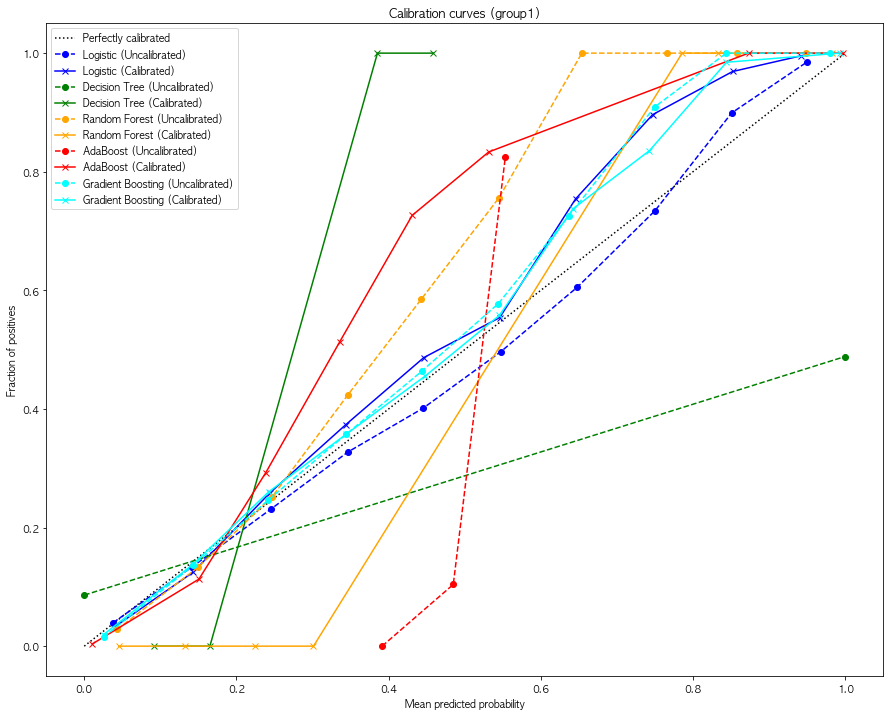

In [65]:
cali_curve_model('group1', X_train1, y_train1, X_val1, y_val1)

In [ ]:
xai_feature_importance('group1', 'Random Forest', X_train1)

In [ ]:
xai_feature_importance_mean('group1', 'Random Forest', X_train1)

In [ ]:
plot_proba_dist('group1', 'Random Forest',  X_val1)

In [89]:
final_metric('group1', 'Gradient Boosting', 'calibration',  X_val1, y_val1)

,accuracy,precision,recall,f1,roc_auc
0,0.900585,0.858042,0.365832,0.51296,0.677862


## 그룹2

In [66]:
group2_df = pd.read_csv('../data/association_rule/group2_df_값생성_2023제거.csv', index_col = 0)

for i in range(1, 9):    
    group2_df.loc[group2_df[f'년도_{i}'].isnull(), f'년도_{i}'] = 0
    
group2_df = group2_df.fillna('')
group2_df = mapping_(group2_df)

X_train2, X_val2, y_train2, y_val2 = split_df(group2_df)

In [67]:
print(f'group2 총 데이터 개수: {len(group2_df)}')
print(f'group2 X_train 데이터 개수: {len(X_train2)}')
print(f'group2 y_train 데이터 개수: {len(y_train2)}')
print(f'group2 X_val 데이터 개수: {len(X_val2)}')
print(f'group2 y_val 데이터 개수: {len(y_val2)}')

group2 총 데이터 개수: 57752
group2 X_train 데이터 개수: 43314
group2 y_train 데이터 개수: 43314
group2 X_val 데이터 개수: 14438
group2 y_val 데이터 개수: 14438


                         category     brier       ece
0           Logistic-Uncalibrated  0.087045  0.011266
1             Logistic-Calibrated  0.084119  0.020441
2      Decision Tree-Uncalibrated  0.160479  0.079443
3        Decision Tree-Calibrated  0.059704  0.131129
4      Random Forest-Uncalibrated  0.084385  0.015697
5        Random Forest-Calibrated  0.007356  0.048312
6           AdaBoost-Uncalibrated  0.231124  0.000000
7             AdaBoost-Calibrated  0.081552  0.037981
8  Gradient Boosting-Uncalibrated  0.079413  0.010377
9    Gradient Boosting-Calibrated  0.074989  0.011894


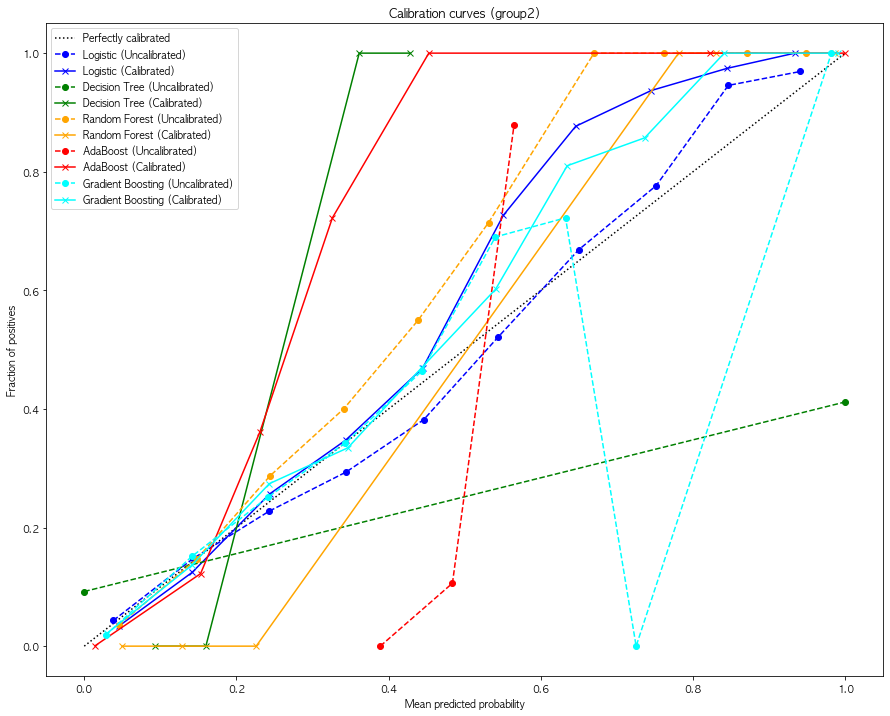

In [69]:
cali_curve_model('group2', X_train2, y_train2, X_val2, y_val2)

In [ ]:
xai_feature_importance('group2', 'Random Forest', X_train2)

In [ ]:
xai_feature_importance_mean('group2', 'Random Forest', X_train2)

In [ ]:
plot_proba_dist('group2', 'Random Forest',  X_val2)

In [90]:
final_metric('group2', 'Logistic', 'uncalibration',  X_val2, y_val2)

,accuracy,precision,recall,f1,roc_auc
0,0.890012,0.733333,0.302136,0.427954,0.642409


## 그룹3

In [72]:
group3_df = pd.read_csv('../data/association_rule/group3_df_값생성_2023제거.csv', index_col = 0)

for i in range(1, 7):    
    group3_df.loc[group3_df[f'년도_{i}'].isnull(), f'년도_{i}'] = 0
    
group3_df = group3_df.fillna('')
group3_df = mapping_(group3_df)

onehot_col = ['멤버십고객여부', '케어십가입여부',
           '최근구매채널', '주거형태', '멤버십가입경로', '제휴카드보유여부', '프리미엄카드보유여부', '제휴가입여부',
           '멤버십앱설치여부', '거주광역명', '거주시군구명', '타겟제품명_1', '타겟제품명_2', '타겟제품명_3',
                   '타겟제품명_4', '타겟제품명_5', '타겟제품명_6', '주구매제품카테고리']
    
# Convert columns in onehot_col to string
for col in onehot_col:
    group3_df[col] = group3_df[col].astype(str)

# 원핫 인코딩
df_encoded = pd.get_dummies(group3_df[onehot_col])
df_encoded = pd.concat([df_encoded, group3_df[['보유멤버십포인트', '최근3년구매금액', '포인트사용빈도', '아파트평형대', '아파트시세',
                                            '건강관리가전품목수', '총구매빈도', '케어솔루션품목수', '케어십품목수', 
                                            'Only&Best품목수', '최대구매가격대', '연령대',
                                            '금액_1', '금액_2', '금액_3', '금액_4', '금액_5', '금액_6',
                                            '년도_1', '년도_2', '년도_3', '년도_4', '년도_5', '년도_6',
                                            '월_1', '월_2', '월_3', '월_4', '월_5', '월_6',
                                             'label_y']]], axis = 1)
X = df_encoded.drop('label_y', axis=1)
y = df_encoded['label_y']
column_names = X.columns

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=column_names)

X_train3, X_val3, y_train3, y_val3 = train_test_split(X_scaled_df, y, test_size=0.25, random_state = 42)

In [73]:
print(f'group3 총 데이터 개수: {len(group3_df)}')
print(f'group3 X_train 데이터 개수: {len(X_train3)}')
print(f'group3 y_train 데이터 개수: {len(y_train3)}')
print(f'group3 X_val 데이터 개수: {len(X_val3)}')
print(f'group3 y_val 데이터 개수: {len(y_val3)}')

group3 총 데이터 개수: 42767
group3 X_train 데이터 개수: 32075
group3 y_train 데이터 개수: 32075
group3 X_val 데이터 개수: 10692
group3 y_val 데이터 개수: 10692


                         category     brier       ece
0           Logistic-Uncalibrated  0.091196  0.018476
1             Logistic-Calibrated  0.088843  0.026798
2      Decision Tree-Uncalibrated  0.156846  0.083053
3        Decision Tree-Calibrated  0.060529  0.134718
4      Random Forest-Uncalibrated  0.087016  0.015165
5        Random Forest-Calibrated  0.007178  0.048725
6           AdaBoost-Uncalibrated  0.232193  0.000000
7             AdaBoost-Calibrated  0.085960  0.024940
8  Gradient Boosting-Uncalibrated  0.082248  0.012660
9    Gradient Boosting-Calibrated  0.075964  0.022381


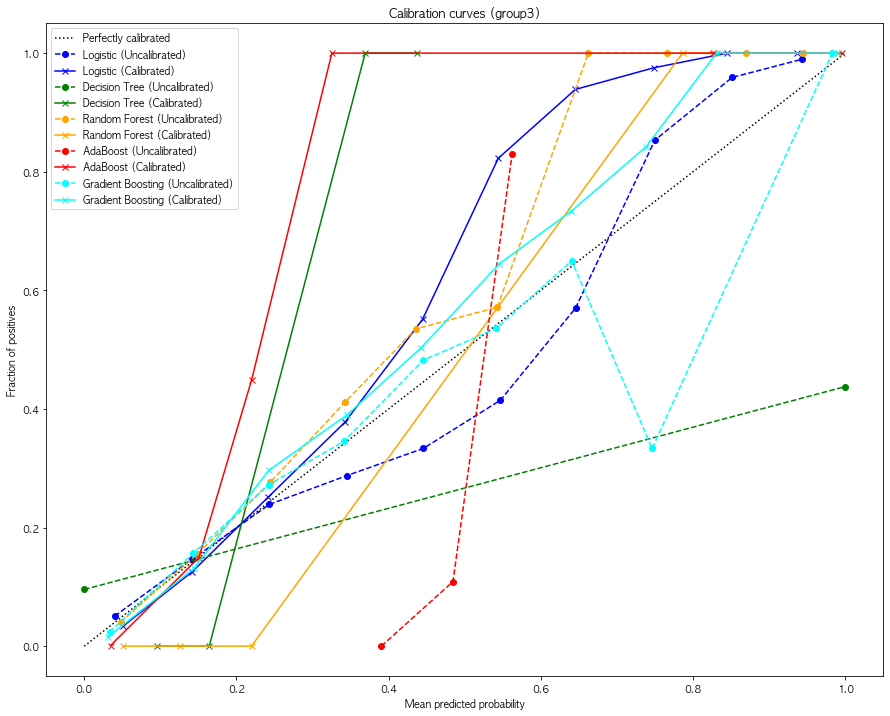

In [74]:
cali_curve_model('group3', X_train3, y_train3, X_val3, y_val3)

In [ ]:
xai_feature_importance('group3', 'Random Forest', X_train3)

In [ ]:
xai_feature_importance_mean('group3', 'Random Forest', X_train3)

In [ ]:
plot_proba_dist('group3', 'Random Forest',  X_val3)

In [91]:
final_metric('group3', 'Logistic', 'uncalibration',  X_val3, y_val3)

,accuracy,precision,recall,f1,roc_auc
0,0.885054,0.724876,0.292943,0.417259,0.637385


## 그룹4

In [75]:
group4_df = pd.read_csv('../data/association_rule/group4_df_값생성_2023제거.csv', index_col = 0)

for i in range(1, 9):    
    group4_df.loc[group4_df[f'년도_{i}'].isnull(), f'년도_{i}'] = 0
    
group4_df = group4_df.fillna('')
group4_df = mapping_(group4_df)

X_train4, X_val4, y_train4, y_val4 = split_df(group4_df)

In [76]:
print(f'group4 총 데이터 개수: {len(group4_df)}')
print(f'group4 X_train 데이터 개수: {len(X_train4)}')
print(f'group4 y_train 데이터 개수: {len(y_train4)}')
print(f'group4 X_val 데이터 개수: {len(X_val4)}')
print(f'group4 y_val 데이터 개수: {len(y_val4)}')

group4 총 데이터 개수: 31620
group4 X_train 데이터 개수: 23715
group4 y_train 데이터 개수: 23715
group4 X_val 데이터 개수: 7905
group4 y_val 데이터 개수: 7905


                         category     brier       ece
0           Logistic-Uncalibrated  0.082996  0.011550
1             Logistic-Calibrated  0.078933  0.035510
2      Decision Tree-Uncalibrated  0.144845  0.072233
3        Decision Tree-Calibrated  0.059325  0.081065
4      Random Forest-Uncalibrated  0.080157  0.010660
5        Random Forest-Calibrated  0.006523  0.045582
6           AdaBoost-Uncalibrated  0.230455  0.000000
7             AdaBoost-Calibrated  0.078348  0.028573
8  Gradient Boosting-Uncalibrated  0.075099  0.005946
9    Gradient Boosting-Calibrated  0.067286  0.022385


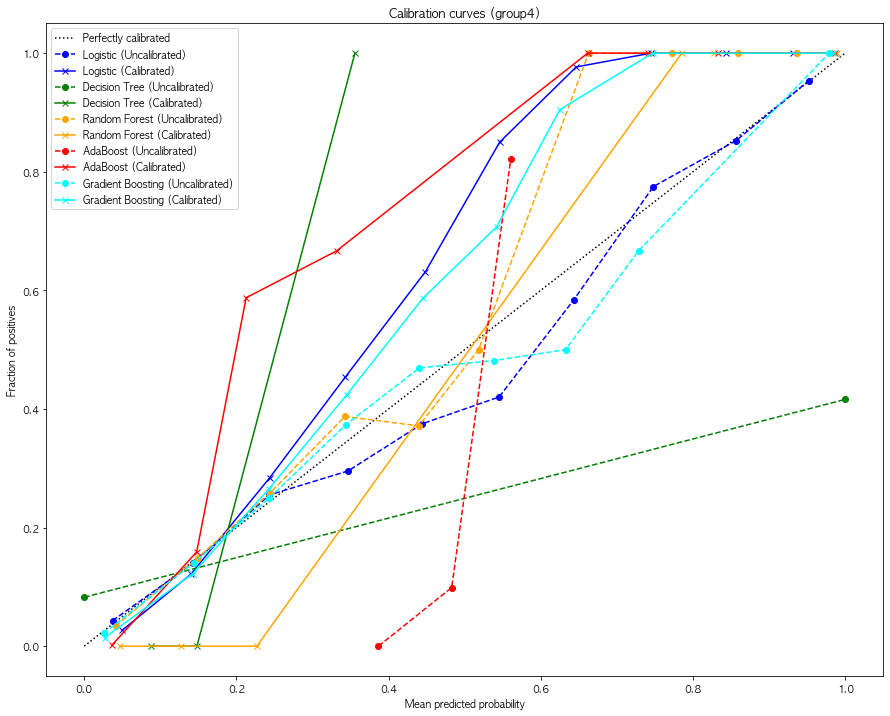

In [77]:
cali_curve_model('group4', X_train4, y_train4, X_val4, y_val4)

In [ ]:
xai_feature_importance('group4', 'Random Forest', X_train4)

In [ ]:
xai_feature_importance_mean('group4', 'Random Forest', X_train4)

In [ ]:
plot_proba_dist('group4', 'Random Forest',  X_val4)

In [92]:
final_metric('group4', 'Gradient Boosting', 'uncalibration',  X_val4, y_val4)

,accuracy,precision,recall,f1,roc_auc
0,0.901581,0.874074,0.240816,0.3776,0.617953


## 그룹5

In [79]:
group5_df = pd.read_csv('../data/association_rule/group5_df_값생성_2023제거.csv', index_col = 0)

for i in range(1, 8):    
    group5_df.loc[group5_df[f'년도_{i}'].isnull(), f'년도_{i}'] = 0
    
group5_df = group5_df.fillna('')
group5_df = mapping_(group5_df)



onehot_col = ['멤버십고객여부', '케어십가입여부',
           '최근구매채널', '주거형태', '멤버십가입경로', '제휴카드보유여부', '프리미엄카드보유여부', '제휴가입여부',
           '멤버십앱설치여부', '거주광역명', '거주시군구명', '타겟제품명_1', '타겟제품명_2', '타겟제품명_3',
                   '타겟제품명_4', '타겟제품명_5', '타겟제품명_6', '타겟제품명_7', '주구매제품카테고리']
    
# Convert columns in onehot_col to string
for col in onehot_col:
    group5_df[col] = group5_df[col].astype(str)

# 원핫 인코딩
df_encoded = pd.get_dummies(group5_df[onehot_col])
df_encoded = pd.concat([df_encoded, group5_df[['보유멤버십포인트', '최근3년구매금액', '포인트사용빈도', '아파트평형대', '아파트시세',
                                            '건강관리가전품목수', '총구매빈도', '케어솔루션품목수', '케어십품목수', 
                                            'Only&Best품목수', '최대구매가격대', '연령대',
                                            '금액_1', '금액_2', '금액_3', '금액_4', '금액_5', '금액_6', '금액_6',
                                            '년도_1', '년도_2', '년도_3', '년도_4', '년도_5', '년도_6', '년도_7',
                                            '월_1', '월_2', '월_3', '월_4', '월_5', '월_6', '월_7',
                                             'label_y']]], axis = 1)
X = df_encoded.drop('label_y', axis=1)
y = df_encoded['label_y']
column_names = X.columns

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=column_names)

X_train5, X_val5, y_train5, y_val5 = train_test_split(X_scaled_df, y, test_size=0.25, random_state = 42)


In [80]:
print(f'group5 총 데이터 개수: {len(group5_df)}')
print(f'group5 X_train 데이터 개수: {len(X_train5)}')
print(f'group5 y_train 데이터 개수: {len(y_train5)}')
print(f'group5 X_val 데이터 개수: {len(X_val5)}')
print(f'group5 y_val 데이터 개수: {len(y_val5)}')

group5 총 데이터 개수: 1883
group5 X_train 데이터 개수: 1412
group5 y_train 데이터 개수: 1412
group5 X_val 데이터 개수: 471
group5 y_val 데이터 개수: 471


                         category     brier       ece
0           Logistic-Uncalibrated  0.135965  0.103057
1             Logistic-Calibrated  0.079036  0.195656
2      Decision Tree-Uncalibrated  0.208068  0.110403
3        Decision Tree-Calibrated  0.077620  0.204264
4      Random Forest-Uncalibrated  0.111663  0.035266
5        Random Forest-Calibrated  0.020091  0.089075
6           AdaBoost-Uncalibrated  0.222066  0.039568
7             AdaBoost-Calibrated  0.097627  0.150776
8  Gradient Boosting-Uncalibrated  0.101349  0.022279
9    Gradient Boosting-Calibrated  0.066501  0.155247


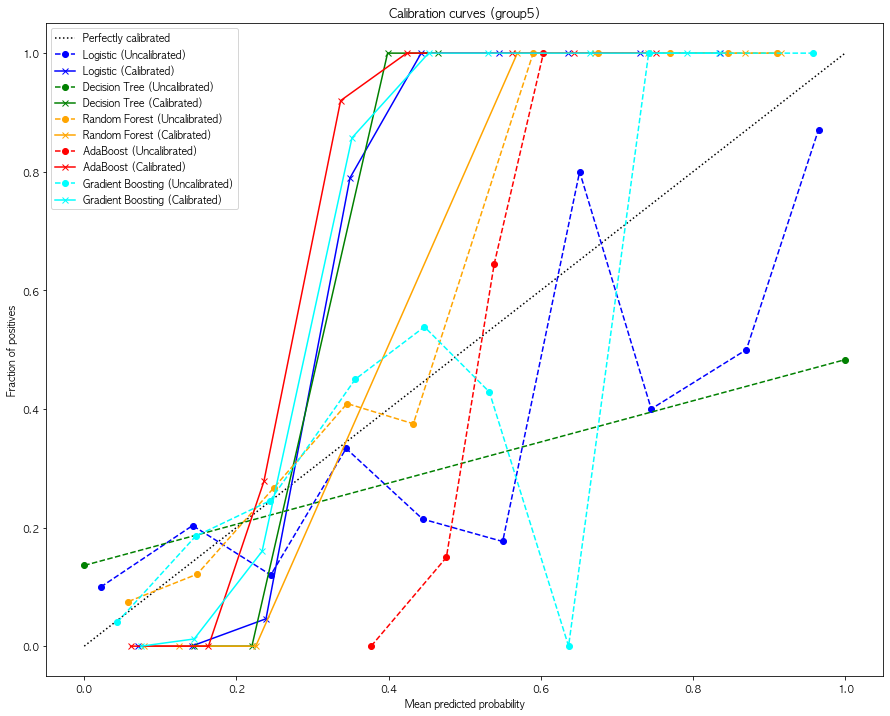

In [81]:
cali_curve_model('group5', X_train5, y_train5, X_val5, y_val5)

In [ ]:
xai_feature_importance('group5', 'Random Forest', X_train5)

In [ ]:
xai_feature_importance_mean('group5', 'Random Forest', X_train5)

In [ ]:
plot_proba_dist('group5', 'Random Forest',  X_val5)

## 그룹6

In [83]:
group6_df = pd.read_csv('../data/association_rule/group6_df_값생성_2023제거.csv', index_col = 0)

for i in range(1, 5):    
    group6_df.loc[group6_df[f'년도_{i}'].isnull(), f'년도_{i}'] = 0
    
group6_df = group6_df.fillna('')
group6_df = mapping_(group6_df)

In [85]:
onehot_col = ['멤버십고객여부', '케어십가입여부',
           '최근구매채널', '주거형태', '멤버십가입경로', '제휴카드보유여부', '프리미엄카드보유여부', '제휴가입여부',
           '멤버십앱설치여부', '거주광역명', '거주시군구명', '타겟제품명_1', '타겟제품명_2', '타겟제품명_3',
                   '타겟제품명_4', '주구매제품카테고리']
    
# Convert columns in onehot_col to string
for col in onehot_col:
    group6_df[col] = group6_df[col].astype(str)

# 원핫 인코딩
df_encoded = pd.get_dummies(group6_df[onehot_col])
df_encoded = pd.concat([df_encoded, group6_df[['보유멤버십포인트', '최근3년구매금액', '포인트사용빈도', '아파트평형대', '아파트시세',
                                            '건강관리가전품목수', '총구매빈도', '케어솔루션품목수', '케어십품목수', 
                                            'Only&Best품목수', '최대구매가격대', '연령대',
                                            '금액_1', '금액_2', '금액_3', '금액_4', 
                                            '년도_1', '년도_2', '년도_3', '년도_4',
                                            '월_1', '월_2', '월_3', '월_4',
                                             'label_y']]], axis = 1)
X = df_encoded.drop('label_y', axis=1)
y = df_encoded['label_y']
column_names = X.columns

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=column_names)

X_train6, X_val6, y_train6, y_val6 = train_test_split(X_scaled_df, y, test_size=0.25, random_state = 42)

In [86]:
print(f'group6 총 데이터 개수: {len(group6_df)}')
print(f'group6 X_train 데이터 개수: {len(X_train6)}')
print(f'group6 y_train 데이터 개수: {len(y_train6)}')
print(f'group6 X_val 데이터 개수: {len(X_val6)}')
print(f'group6 y_val 데이터 개수: {len(y_val6)}')

group6 총 데이터 개수: 5900
group6 X_train 데이터 개수: 4425
group6 y_train 데이터 개수: 4425
group6 X_val 데이터 개수: 1475
group6 y_val 데이터 개수: 1475


                         category     brier       ece
0           Logistic-Uncalibrated  0.107875  0.046749
1             Logistic-Calibrated  0.099578  0.112562
2      Decision Tree-Uncalibrated  0.188475  0.092881
3        Decision Tree-Calibrated  0.080958  0.623616
4      Random Forest-Uncalibrated  0.102169  0.021702
5        Random Forest-Calibrated  0.014316  0.066261
6           AdaBoost-Uncalibrated  0.217214  0.000000
7             AdaBoost-Calibrated  0.097061  0.095220
8  Gradient Boosting-Uncalibrated  0.095447  0.020121
9    Gradient Boosting-Calibrated  0.070067  0.088119


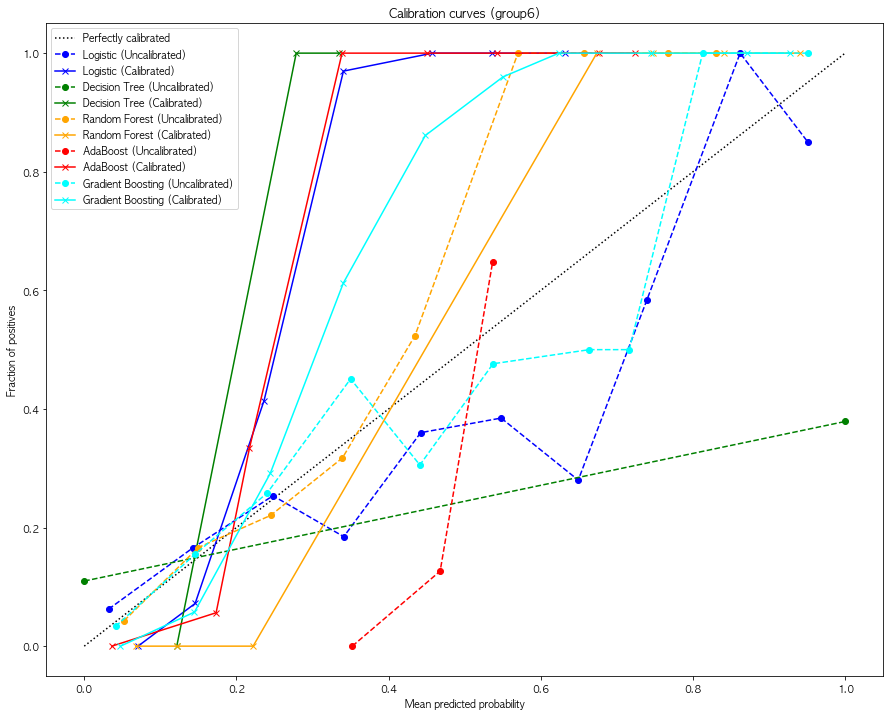

In [87]:
cali_curve_model('group6', X_train6, y_train6, X_val6, y_val6)

In [ ]:
xai_feature_importance('group6', 'Random Forest', X_train6)

In [ ]:
xai_feature_importance_mean('group6', 'Random Forest', X_train6)

In [ ]:
plot_proba_dist('group6', 'Random Forest',  X_val6)